In [7]:
import os
import xml.etree.ElementTree as ET
import numpy as np
def filelist(root, file_type):
    return [os.path.join(directory_path, f) for directory_path, directory_name, files in os.walk(root) for f in files if f.endswith(file_type)]

split = "test"
data_path="/Users/yacineflici/Documents/master-vmi/s2/TER/DIOR-RS-VG/"
images_path="/Users/yacineflici/Documents/master-vmi/s2/TER/DIOR-RS-VG/JPEGImages/"
anno_path="/Users/yacineflici/Documents/master-vmi/s2/TER/DIOR-RS-VG/Annotations/"
images = []
file = open(data_path + split + '.txt', "r").readlines()
Index = [int(index.strip('\n')) for index in file]
count = 0
annotations = filelist(anno_path, '.xml')
for anno_path in annotations:
    root = ET.parse(anno_path).getroot()
    for member in root.findall('object'):
        if count in Index:
            imageFile = root.find("./filename").text
            image_pth = imageFile.replace(".jpg", ".pth")
            box = ([int(member[2][0].text), int(member[2][1].text), int(member[2][2].text), int(member[2][3].text)])
            text = member[3].text
            images.append((imageFile,image_pth, box, text))
        count += 1

print(images[0])

('00873.jpg', '00873.pth', [292, 332, 413, 447], 'A yellow and white small storage tank in the middle')


[ 96.88  73.92 110.04 154.84]


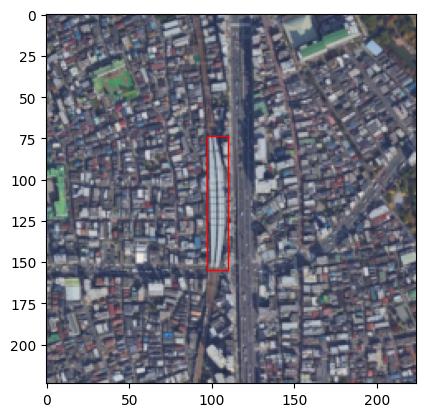

In [35]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

#show this image 
images_path = "/Users/yacineflici/Documents/master-vmi/s2/TER/DIOR-RS-VG/JPEGImages/"
image = "04989.jpg"

img = plt.imread(images_path + image)
img = F.to_pil_image(img)
size = 224
rectangle = np.array([346, 264, 393, 553])
h, w = img.height, img.width
ratio = float(size / float(max(h, w)))
new_w, new_h = round(w* ratio), round(h * ratio)
img = F.resize(img, (new_h, new_w))
rectangle = rectangle * ratio
print(rectangle)
#draw rectangle
#resize img to exactly 224x224
# img.resize((224,224))
plt.gca().add_patch(plt.Rectangle((rectangle[0],rectangle[1]),rectangle[2]-rectangle[0],rectangle[3]-rectangle[1],fill=None, edgecolor='r'))
plt.imshow(img)

In [16]:
#read outputs/iou.txt
numbers = open("./outputs/iou.txt", "r").read()
numbers = numbers.replace("]","").replace("[", "").replace("\n", "").replace(" ", "").split(",")
numbers = [float(number) for number in numbers]

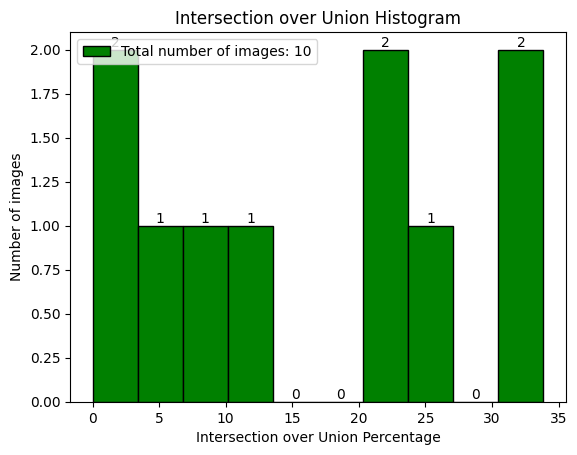

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'numbers' is defined elsewhere and is a list of your IoU values (as fractions, not percentages)
numbers_percet = [number * 100 for number in numbers]

# Calculate histogram data
counts, bins = np.histogram(numbers_percet, bins=10)

# Plot histogram
plt.hist(bins[:-1], bins, weights=counts, color="green", edgecolor='black')

# Add number of images on top of each bar
for i in range(len(bins) - 1):
    plt.text(bins[i] + (bins[i+1] - bins[i]) / 2, counts[i], str(counts[i]), ha='center', va='bottom')

# Add title
plt.title("Intersection over Union Histogram")

# Add x label
plt.xlabel("Intersection over Union Percentage")

# Add y label
plt.ylabel("Number of images")

# Add legend saying total number of images
plt.legend(["Total number of images: " + str(len(numbers))])

# Show the plot
plt.show()


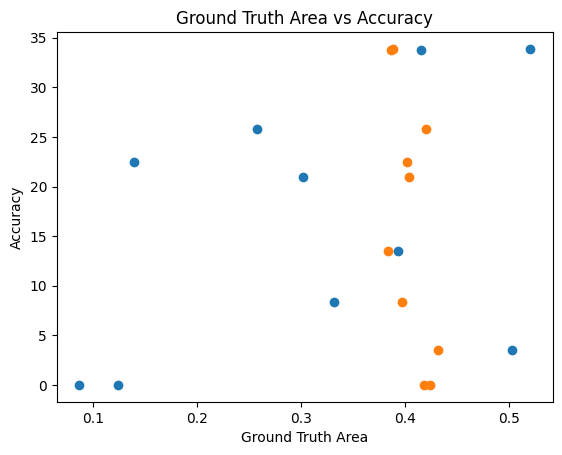

In [18]:
#read outputs/gt_area.txt
gt_areas = open("./outputs/gt_area.txt", "r").read()
gt_areas = gt_areas.replace("]","").replace("[", "").replace("\n", "").replace(" ", "").split(",")
pred_areas = open("./outputs/pred_area.txt", "r").read()
pred_areas = pred_areas.replace("]","").replace("[", "").replace("\n", "").replace(" ", "").split(",")
#plot gt_area/accuracy
gt_areas = [float(area) for area in gt_areas]
pred_areas = [float(area) for area in pred_areas]
plt.scatter(gt_areas, numbers_percet)
plt.scatter(pred_areas, numbers_percet)
plt.xlabel("Ground Truth Area")
plt.ylabel("Accuracy")
plt.title("Ground Truth Area vs Accuracy")
plt.show()


In [1]:
import torch 
from utils.eval_utils import trans_vg_eval_test,trans_vg_mean_iou,trans_vg_cumulative_iou

#load tensors 

pred_boxes = torch.load("./outputs/pred_boxes8_lr1.pth")
gt_boxes = torch.load("./outputs/gt_boxes8_lr1.pth")
total_num = pred_boxes.shape[0]

results_dict = {
    "Pr@0.5": float(trans_vg_eval_test(pred_boxes, gt_boxes, 0.5)/total_num),
    "Pr@0.6" : float(trans_vg_eval_test(pred_boxes, gt_boxes, 0.6)/total_num),
    "Pr@0.7" : float(trans_vg_eval_test(pred_boxes, gt_boxes, 0.7)/total_num),
    "Pr@0.8" : float(trans_vg_eval_test(pred_boxes, gt_boxes, 0.8)/total_num),
    "Pr@0.9" : float(trans_vg_eval_test(pred_boxes, gt_boxes, 0.9)/total_num),
    "meanIoU" : float(trans_vg_mean_iou(pred_boxes, gt_boxes)),
    "cumIoU" : float(trans_vg_cumulative_iou(pred_boxes, gt_boxes))
    
}
print(results_dict)

/Users/yacineflici/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'Pr@0.5': 0.4705333411693573, 'Pr@0.6': 0.38493332266807556, 'Pr@0.7': 0.2831999957561493, 'Pr@0.8': 0.15306666493415833, 'Pr@0.9': 0.028933333232998848, 'meanIoU': 0.4583558142185211, 'cumIoU': 0.5697818398475647}


In [6]:
from utils.loss_utils import trans_vg_loss
import torch
pred_boxes = torch.load("./outputs/pred_boxes.txt")
gt_boxes = torch.load("./outputs/gt_boxes.txt")

val_dict = trans_vg_loss( pred_boxes, gt_boxes)
print(val_dict.values(), val_dict.keys())

dict_values([tensor(0.7455), tensor(0.9020)]) dict_keys(['loss_bbox', 'loss_giou'])


In [4]:
import torch 
from utils.eval_utils import trans_vg_eval_test_giou,trans_vg_eval_test,avg_size_difference,avg_position_difference,bounding_box_regression_loss,trans_vg_eval_test_iom

#load tensors 

pred_boxes = torch.load("pred_boxes8_lr1.pth")
gt_boxes = torch.load("gt_boxes8_lr1.pth")
total_num = pred_boxes.shape[0]

accu_num = trans_vg_eval_test(pred_boxes, gt_boxes)
goui = trans_vg_eval_test_giou(pred_boxes, gt_boxes)/ float(total_num)
avg_size_diff = avg_size_difference(pred_boxes, gt_boxes)
avg_pos_diff =    avg_position_difference(pred_boxes, gt_boxes)
reg_loss = bounding_box_regression_loss(pred_boxes, gt_boxes)
accu_num_iom = trans_vg_eval_test_iom(pred_boxes, gt_boxes)
accuracy = float(accu_num) / float(total_num)
accuracy_iom = accu_num_iom / total_num
print("accuracy GIoU: ", goui)
print("accuracy IoU: ", accuracy)
print("accuracy IoM: ", accuracy_iom)
print("avg_size_diff: ", avg_size_diff)
print("avg_pos_diff: ", avg_pos_diff)
print("reg_loss: ", reg_loss)

accuracy GIoU:  0.7808
accuracy IoU:  0.5265333333333333
accuracy IoM:  0.09946666666666666
avg_size_diff:  (tensor(0.0375), tensor(0.0378))
avg_pos_diff:  (tensor(0.0706), tensor(0.0673))
reg_loss:  tensor(0.2132)
